In [198]:
import csv
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

### Importation des données et nettoyage 

In [199]:
def importClean_10ind(csv_file_path, desired_returns):
    """
    Cette fonction importe des données à partir d'un fichier CSV spécifié, effectue un nettoyage de données,
    et retourne un DataFrame contenant des données filtrées sans tenir compte de la variable T (nombre d'années).

    Args:
        csv_file_path(str): Chemin vers le fichier CSV avec les données brutes.

    Returns:
        DataFrame: DataFrame contenant les données historiques filtrées pour les 10 industries.
    """


    # Importation
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        
        # Sauter les 6 premières lignes
        for _ in range(10):
            next(reader)

        # Lire le reste du fichier CSV dans un DataFrame
        df = pd.DataFrame(reader)
        df.columns = df.iloc[1]
        df = df.drop(df.index[1])
        df = df.reset_index(drop=True)

    # Nettoyage
    df = df.rename(columns={df.columns[0]: 'Date'})
    first_row = df[df.iloc[:, 0].str.strip() == desired_returns].index
    
    # Si 'desired_returns' est 'Number of Firms in Portfolios' ou 'Average Firm Size', 
    # alors sauter une ligne supplémentaire pour accéder aux données dans le bon format
    if desired_returns in ['Number of Firms in Portfolios', 'Average Firm Size']:
        df_AEWR_monthly = df.iloc[first_row.values[0] + 2:].reset_index(drop=True)
    else:
        df_AEWR_monthly = df.iloc[first_row.values[0] + 1:].reset_index(drop=True)
        
    last_row = (df_AEWR_monthly['Date'].str.len() != 6).idxmax()
    df_AEWR_monthly = df_AEWR_monthly.iloc[:last_row]
    df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y%m')
    df_AEWR_monthly.iloc[:, 1:] = df_AEWR_monthly.iloc[:, 1:].astype(float)

    # Retourner le DataFrame et fixer la 'Date' comme index  
    df = df_AEWR_monthly.set_index('Date', drop=True)
    
    return (df)

In [200]:
csv_file_path_10ind = 'Data /10_Industry_Portfolios.CSV'
df_10Ind       = importClean_10ind(csv_file_path_10ind, desired_returns= 'Average Value Weighted Returns -- Monthly')

df_10Ind

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07-01,1.45,15.55,4.69,-1.18,2.9,0.83,0.11,1.77,7.04,2.13
1926-08-01,3.97,3.68,2.81,3.47,2.66,2.17,-0.71,4.25,-1.69,4.35
1926-09-01,1.14,4.8,1.15,-3.39,-0.38,2.41,0.21,0.69,2.04,0.29
1926-10-01,-1.24,-8.23,-3.63,-0.78,-4.58,-0.11,-2.29,-0.57,-2.63,-2.84
1926-11-01,5.2,-0.19,4.1,0.01,4.71,1.63,6.43,5.42,3.71,2.11
...,...,...,...,...,...,...,...,...,...,...
2023-09-01,-4.57,-2.58,-7.08,3.17,-5.98,-3.22,-5.68,-4.71,-5.04,-3.41
2023-10-01,-3.53,-17.88,-2.76,-6.24,-1.78,-0.18,0.47,-4.58,1.12,-2.53
2023-11-01,5.02,15.76,8.68,-1.29,11.96,6.97,7.18,5.87,5.08,10.41


### Importation du taux sans risque historique

In [201]:
def importClean_rf(csv_file_path):
    """
    Cette fonction importe des données à partir du fichier CSV des 3 facteurs Fama-French, puis effectue un nettoyage de données
    et retourne un DataFrame contenant des données filtrées spécifiquement pour les taux sans risque dans la colonne 'RF'.

    Args:
        csv_file_path (str): Chemin vers le fichier CSV avec les données brutes.

    Returns:
        DataFrame: DataFrame contenant les données nettoyées pour les taux sans risque.
    """
    
    # Importation des données en sautant les 3 premières lignes
    df = pd.read_csv(csv_file_path, skiprows=3)  

    # Renommage des colonnes pour faciliter la manipulation
    df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

    # Suppression des lignes dont la date ne correspond pas au format '%Y%m'
    df = df[df['Date'].str.match(r'^\d{6}$', na=False)]

    # Conversion de 'Date' en datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')

    # Conversion de 'RF' en float
    df['RF'] = df['RF'].astype(float)
    
    # Filtrage des colonnes 
    df = df[['Date', 'RF']] 
    
    # Mise en index de la colonne 'Date'
    df.set_index('Date', inplace=True)
    
    # Retourner le DataFrame nettoyé pour les taux sans risque
    return df

In [202]:
csv_file_path_rf = 'Data /F-F_Research_Data_Factors.CSV'
df_rf         = importClean_rf(csv_file_path_rf)
df_rf

,RF
Date,
1926-07-01,0.22
1926-08-01,0.25
1926-09-01,0.23
1926-10-01,0.32
1926-11-01,0.31
...,...
2023-09-01,0.43
2023-10-01,0.47
2023-11-01,0.44


# 7) Calcul du Portefeuille à Variance Minimale (Approche numérique):


In [203]:
def MV_optimize_portfolio(z_bar, Sigma, short_allowed=False):
    """
    Calcul les poids optimaux qui minimisent la variance du portefeuille avec une contrainte de budget dans les deux cas avec et sans contrainte de vente à découvert,
    en utilisant le solveur de programmation linéaire GUROBI.
    
    Parameters:
    - z_bar (Series): Série pandas contenant les rendements attendus pour chaque actif du portefeuille d'industrie.
    - Sigma (DataFrame): DataFrame pandas représentant la matrice de covariance des rendements des actifs du portefeuille. 
    - short_allowed (bool): Booléen indiquant si les positions de ventes à découvert sont autorisées (True) ou non autorisées (False).

    Returns:
    - df_results (pd.DataFrame): Un DataFrame pandas contenant les poids optimaux pour chaque actif (optimal_w) si l'optimisation a convergé vers une solution.
    """
    
    
    # Récupérer les actifs et le retour cible
    assets = z_bar.index
    # mu_target = 0.02  

    # Création d'un nouveau modèle d'optimisation linéaire
    m = gp.Model("MV_portfolio")

    # Création de variables pour les poids de chaque actif dans le portefeuille
    if short_allowed:
        weights = m.addVars(assets, lb=-GRB.INFINITY, name="weights")
    else:
        weights = m.addVars(assets, lb=0, ub=1, name="weights")

    # Variance du portefeuille (objectif à minimiser) : w^T * Sigma * w 
    portfolio_variance = sum(weights[i] * Sigma.loc[i, j] * weights[j] for i in assets for j in assets)

    # Définir l'objectif pour minimiser la variance du portefeuille 
    m.setObjective(portfolio_variance, GRB.MINIMIZE)

    # Ajouter des contraintes pour le budget et le retour cible
    m.addConstr(sum(weights[asset] for asset in assets) == 1, "budget")
    # m.addConstr(sum(weights[asset] * z_bar[asset] for asset in assets) >= mu_target, "target_return") # Contrainte optionnelle pour le retour cible 

    # Optimiser le modèle 
    m.Params.LogToConsole = 0
    m.optimize()

    # Vérifier si l'optimisation a été réussie 
    if m.status == GRB.OPTIMAL:
        
        # Obtenir les poids optimaux et la variance si l'optimisation est réussie 
        optimal_w = {asset: weights[asset].X for asset in assets}

        # Créer un DataFrame pour les résultats optimaux
        df_results = pd.DataFrame(optimal_w, index=[0])
    else:
        print("Optimization was unsuccessful. Unable to retrieve the solution.")
        return None
    
    return df_results

# 1) 2) Calcul du Portefeuille qui maximise le ratio de Sharpe (Approche numérique) avec/sans contrainte de vente à découverte:

In [204]:
def max_sharpe(z_bar, Sigma, Rf, short_allowed = False):
    """
    Calcul les poids optimisés des actifs dans le portefeuille qui maximisent le ratio de Sharpe avec et sans contrainte de vente à découvert,
    en utilisant le solveur de programmation linéaire GUROBI.

    Parameters:
    - z_bar (Series): Les rendements attendus de chacun des actifs.
    - Sigma (DataFrame): La matrice de covariance des rendements des actifs. 
    - Rf (float): Le taux de rendement sans risque mensuel.
    - short_allowed (bool): Autorise ou non les positions courtes dans le portefeuille.

    Returns:
    - weights_df (pd.DataFrame): Un dataFrame contenant les poids optimaux de chaque actif dans le portefeuille qui maximise le ratio de sharpe.
    """
    
    
    # Identifier les actifs et leur nombre
    assets = z_bar.index
    number_of_assets = len(assets)
    
    # Initialiser le modèle d'optimisation
    model = gp.Model("max_sharpe")
    
    # Désactiver l'affichage de la console 
    model.Params.LogToConsole = 0
    model.Params.OutputFlag = 0

    # Définir les variables de décision: les poids y et la variable auxiliaire kappa
    if short_allowed : 
        y = model.addVars(assets, lb=-100.0, name='weights')
    else: 
        y = model.addVars(assets, lb=0, name='weights')
    
    kappa = model.addVar(lb=0.0, name='kappa') 
    
    # Construire le vecteur des poids y
    y_vector = [y[i] for i in assets]

    # Calculer la variance du portefeuille (sigma_p) en fonction des poids y et de la matrice de covariance Sigma 
    sigma_p = sum(y_vector[i] * y_vector[j] * Sigma.loc[assets[i], assets[j]]
                    for i in range(number_of_assets) for j in range(number_of_assets))
    
    # Ajouter des contraintes au modèle d'optimisation 
    model.addConstr(sum((z_bar[i] - Rf) * y[i] for i in assets) == 1, "Rendement ajusté") # Contrainte de rendement ajusté normalisé selon k 
    model.addConstr(sum(y[i] for i in assets) == kappa) # Constrainte nécessaire pour que kappa ne soit pas nul 
    
    # Définir l'objectif: Minimiser la variance du portefeuille (Maximiser le ratio de Sharpe)
    model.setObjective(sigma_p, GRB.MINIMIZE)
    
    # Exécuter l'optimisation
    model.optimize()
    
    # Vérifier si la solution optimale a été trouvée
    if model.status == GRB.OPTIMAL:
        y_opt = model.getAttr('x', y) # Poids optimaux y
        kappa_opt = kappa.X # Valeur optimale de kappa
        
        # Calculer et ajuster les poids du portefeuille original x à partir de y et kappa 
        x_opt = {i: y_opt[i] / (kappa_opt) for i in assets}
        
        # Convertir les poids en DataFrame 
        weights_df = pd.DataFrame([x_opt], columns=assets)
        
        return weights_df
    else:
        print("Optimization non réussie. Impossible de retrouver la solution à cette date précise.")
        return None

In [205]:
def max_sharpe(z_bar, Sigma, Rf, short_allowed = False):
    """
    Calcul les poids optimisés des actifs dans le portefeuille qui maximisent le ratio de Sharpe avec et sans contrainte de vente à découvert,
    en utilisant le solveur de programmation linéaire GUROBI dans le cas avec contrainte sur vente à découverte et analytiquement pour le cas 
    sans contrainte de vente à découvert.

    Parameters:
    - z_bar (Series): Les rendements attendus de chacun des actifs.
    - Sigma (DataFrame): La matrice de covariance des rendements des actifs.
    - Rf (float): Le taux de rendement sans risque mensuel.
    - short_allowed (bool): Autorise ou non les positions courtes dans le portefeuille.

    Returns:
    - weights_df (pd.DataFrame): Un dataFrame contenant les poids optimaux de chaque actif dans le portefeuille qui maximise le ratio de sharpe.
    """
    # Identifier les actifs et leur nombre
    assets = z_bar.index
    number_of_assets = len(assets)

    if short_allowed == False:
        # Initialiser le modèle d'optimisation
        model = gp.Model("max_sharpe")
        
        # Désactiver l'affichage de la console
        model.Params.LogToConsole = 0
        model.Params.OutputFlag = 0

        # Définir les variables de décision: les poids y et la variable auxiliaire kappa
        if short_allowed :
            y = model.addVars(assets, lb=-100.0, name='weights')
        else:
            y = model.addVars(assets, lb=0, name='weights')
        
        kappa = model.addVar(lb=0.0, name='kappa')
        
        # Construire le vecteur des poids y
        y_vector = [y[i] for i in assets]

        # Calculer la variance du portefeuille (sigma_p) en fonction des poids y et de la matrice de covariance Sigma
        sigma_p = sum(y_vector[i] * y_vector[j] * Sigma.loc[assets[i], assets[j]]
                        for i in range(number_of_assets) for j in range(number_of_assets))
        
        # Ajouter des contraintes au modèle d'optimisation
        model.addConstr(sum((z_bar[i] - Rf) * y[i] for i in assets) == 1, "Rendement ajusté") # Contrainte de rendement ajusté normalisé selon k
        model.addConstr(sum(y[i] for i in assets) == kappa) # Constrainte nécessaire pour que kappa ne soit pas nul
        
        # Définir l'objectif: Minimiser la variance du portefeuille (Maximiser le ratio de Sharpe)
        model.setObjective(sigma_p, GRB.MINIMIZE)
        
        # Exécuter l'optimisation
        model.optimize()
        
        # Vérifier si la solution optimale a été trouvée
        if model.status == GRB.OPTIMAL:
            y_opt = model.getAttr('x', y) # Poids optimaux y
            kappa_opt = kappa.X # Valeur optimale de kappa
            
            # Calculer et ajuster les poids du portefeuille original x à partir de y et kappa
            x_opt = {i: y_opt[i] / (kappa_opt) for i in assets}
            
            # Convertir les poids en DataFrame
            weights_df = pd.DataFrame([x_opt], columns=assets)
            
            return weights_df
        else:
            print("Optimization non réussie. Impossible de retrouver la solution à cette date précise.")
            return None
    else:
        # Utiliser la formule analytique pour les poids du portefeuille tangent (qui maximise le ratio de Sharpe)
        one = np.ones(number_of_assets)
        A = np.dot(one, np.dot(np.linalg.inv(Sigma), one.T))
        B = np.dot(one, np.dot(np.linalg.inv(Sigma), z_bar))
        w = (np.dot(np.linalg.inv(Sigma), z_bar - Rf*np.ones(number_of_assets))/(B - A*Rf)).tolist()

        # Convertir les poids en DataFrame
        weights = {n: w[i] for i, n in enumerate(assets)}
        weights_df = pd.DataFrame([weights], columns=assets)

        return weights_df

# 3) Calcul du Portefeuille où le poids de chaque actif est inversement relié à sa variance:

In [206]:
def Inverse_Variance_Portfolio(Sigma):
    """
    Calcule le portefeuille où les poids des actifs sont inversement proportionnels à la variance de l'actif.
    
    Parameters:
    - Sigma (Dataframe): La matrice de covariance des rendements des actifs. 
    
    Returns:
    - normalized_weights (DataFrame): Un dataFrame contenant les poids optimaux (inversement reliés à la variance) de chaque actif dans le portefeuille.
    """
    
    
    # Extraire les variances de la diagonale de la matrice de covariance Sigma 
    variances = Sigma.values.diagonal()
    
    # Calculer l'inverse de chaque variance
    # Objectif : donner plus de poids aux actifs ayant une plus faible variance
    inverse_variance_weights = 1 / variances
    
    # Normaliser les poids inverses de la variance pour qu'ils somment à 1
    normalized_weights_var = inverse_variance_weights / inverse_variance_weights.sum()
    
    # Convertir le tableau numpy de poids normalisés en un DataFrame pandas
    normalized_weights_var = pd.DataFrame([normalized_weights_var], columns=Sigma.index)
    
    # Retourner le DataFrame des poids normalisés 
    return normalized_weights_var

# 4) Calcul du portefeuille où le poids de chaque actif est inversement relié à sa volatilité:

In [207]:
def Inverse_Volatility_Portfolio(Sigma):
    """
    Calcule les poids du portefeuille qui sont inversement proportionnels à la volatilité de chaque actif.
    
    Parameters:
    - Sigma (Dataframe):  DataFrame Pandas représentant la matrice de covariance des rendements des actifs. 
    
    Returns:
    - normalized_weights_std (Dataframe): Un dataFrame contenant les poids optimaux (inversement reliés à la volatilité) de chaque actif dans le portefeuille.
    """
    
    
    # Calcule la volatilité (écart type de la variance) pour chaque actif
    volatilites = np.sqrt(Sigma.values.diagonal())

    # Calcule l'inverse de la volatilité pour chaque actif
    # Objectif : donner plus de poids aux actifs moins volatils (c'est-à-dire ceux ayant une faible volatilité)
    inverse_volatility_weights = 1 / volatilites

    # Normaliser les poids inverses de la volatilité pour qu'ils somment à 1
    normalized_weights_std = inverse_volatility_weights / inverse_volatility_weights.sum()

    # Convertir le tableau numpy de poids normalisés en un DataFrame pandas
    normalized_weights_std = pd.DataFrame([normalized_weights_std], columns=Sigma.index)

    # Retourner le DataFrame des poids normalisés
    return normalized_weights_std

# 5) Calcul du portefeuille où les actifs ont les mêmes poids:

In [208]:
def Equally_Weighted_Portfolio(assets):
    """
    Calcule les poids équipondérés (1/N) pour chaque actif dans le portefeuille de 10 industries.
    
    Parameters:
    - Assets: DataFrame Pandas représentant le nombre d'actifs dans le portefeuille.
    
    Returns:
    - portfolio_weights (Dataframe) : Un dataFrame contenant des poids égaux pour chaque actif dans le portefeuille 1/N.
    """
    
    
    # Nombre d'actifs dans le portefeuille d'industries
    n_assets = len(assets) 
    
    # Poids équipondérés dans le portefeuille (1/N pour chaque actif)
    equal_weight = 1 / n_assets 
    
    # Créer un dictionnaire de poids pour chaque actif
    EW_portfolio_weights = {asset: equal_weight for asset in assets}
    
    # Convertir le dictionnaire de poids en un DataFrame pandas
    EW_portfolio_weights = pd.DataFrame([EW_portfolio_weights], columns=assets)
    
    return EW_portfolio_weights

# 6) Calcul du  portefeuille où le poids de chaque est linéairement relié à sa capitalisation boursière

In [209]:
df_number_firm = importClean_10ind('/Users/thomasdeconinck/Documents/GitHub/Gestion de Portefeuille Devoir 2/Partie A/Data /10_Industry_Portfolios.CSV', desired_returns='Number of Firms in Portfolios')

df_average_firm_size = importClean_10ind('/Users/thomasdeconinck/Documents/GitHub/Gestion de Portefeuille Devoir 2/Partie A/Data /10_Industry_Portfolios.CSV', desired_returns='Average Firm Size')


In [210]:
df_average_firm_size

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07-01,31.58,53.05,38.49,84.59,89.75,350.36,39.19,25.52,81.22,51.64
1926-08-01,32.0,61.05,40.17,83.49,92.3,353.27,39.13,25.8,86.81,52.59
1926-09-01,33.18,62.94,41.16,86.27,94.49,360.96,38.76,26.73,85.01,54.68
1926-10-01,33.32,65.75,41.39,82.94,93.38,364.16,38.77,26.87,86.41,54.59
1926-11-01,32.83,60.18,39.77,82.19,89.05,363.74,37.79,26.54,83.92,52.9
...,...,...,...,...,...,...,...,...,...,...
2023-09-01,10918.12,12555.54,9187.91,15647.61,23460.59,17569.83,15575.29,4836.84,15768.88,7670.72
2023-10-01,10371.66,12229.42,8591.73,16124.78,22089.34,17002.66,14841.46,4662.93,14934.55,7465.77
2023-11-01,10103.75,10036.02,8424.81,15330.62,21778.41,16864.67,15000.88,4503.19,15076.79,7304.9


In [211]:
df_number_firm

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07-01,90.0,37.0,127.0,51.0,18.0,5.0,41.0,7.0,21.0,113.0
1926-08-01,90.0,37.0,127.0,51.0,18.0,5.0,41.0,7.0,21.0,113.0
1926-09-01,90.0,37.0,127.0,50.0,18.0,5.0,41.0,7.0,21.0,113.0
1926-10-01,90.0,37.0,127.0,50.0,18.0,5.0,41.0,7.0,21.0,113.0
1926-11-01,90.0,37.0,127.0,50.0,18.0,5.0,41.0,7.0,21.0,113.0
...,...,...,...,...,...,...,...,...,...,...
2023-09-01,152.0,92.0,382.0,110.0,684.0,56.0,287.0,870.0,76.0,1205.0
2023-10-01,152.0,92.0,379.0,110.0,679.0,56.0,284.0,859.0,76.0,1194.0
2023-11-01,150.0,92.0,375.0,108.0,672.0,56.0,282.0,847.0,76.0,1188.0


In [212]:
def Market_Cap_Weighted_Portfolio(df_average_firm_size, df_number_firm):
    """
    Cette fonction calcule les poids proportionnels à la capitalisation boursière pour chaque actifs dans le portefeuille d'industries,
    étant donné la taille moyenne des entreprises et le nombre d'entreprises.
    
    Parameters:
    - df_average_firm_size: DataFrame représentant la taille moyenne de l'entreprise pour chaque actif dans le portefeuille au fil du temps.
    - df_number_firm: DataFrame représentant le nombre d'entreprises pour chaque actif dans le portefeuille au fil du temps.
    
    Returns:
    - weights: DataFrame contenant les poids selon la capitalisation boursière pour chaque actif dans le portefeuille.
    """
    
    
    # Calcule la capitalisation boursière pour chaque actif dans le portefeuille au fil du temps
    market_caps = df_average_firm_size.multiply(df_number_firm)
    
    # Calcule la capitalisation boursière totale pour tous les actifs pour chaque date
    total_market_cap = market_caps.sum(axis=1)
    
    # Calcule les poids pour chaque actif en divisant la capitalisation boursière de chaque actif par la capitalisation boursière totale
    VW_portfolio_weights = market_caps.div(total_market_cap, axis='index')
    
    # Retourne les poids du portefeuille optimal dans un DataFrame 
    VW_portfolio_weights = pd.DataFrame(VW_portfolio_weights, columns=df_average_firm_size.columns)
    
    return VW_portfolio_weights

## Fenêtre "Rolling" de données de 5 ans de 10 portefeuilles d'industrie, qui calcule les portefeuilles suivants pour chaque mois depuis juin 1931 : 
- 1) le portefeuille qui maximise le ratio de Sharpe sans contrainte de vente à découverte
- 2) le portefeuille qui maximise le ratio de Sharpe avec contrainte de vente à découverte
- 3) le portefeuille ou le poids de chaque actif est inversement relié à sa variance
- 4) le portefeuille ou le poids de chaque actif est inversement relié à sa volatilité
- 5) le portefeuille ou les actifs ont les mêmes poids
- 6) le portefeuille ou le poids de chaque est linéairement relié à sa capitalisation boursière
- 7) le portefeuille avec la minimum variance

In [213]:
def rolling_window_optimization(df, window_size, optimization_type='min_variance', short_allowed=False):
    """
    Calculate portfolio weights for each window using a rolling window based on the specified optimization type.

    Args:
    - df (DataFrame): DataFrame containing asset returns for each month with dates as index.
    - window_size (int): Size of the rolling window in months.
    - optimization_type (str): Type of portfolio optimization to perform ('min_variance' for minimum variance portfolio, or other types as needed).
    - short_allowed (bool): Whether short selling is allowed in the optimization.

    Returns:
    - results_df (DataFrame): DataFrame containing portfolio weights for each window with associated dates.
    """   
    results = []
    dates = []

    for start_idx in range(len(df) - window_size + 1):
        window_data = df.iloc[start_idx:start_idx + window_size]
        window_average_firm_size = df_average_firm_size.iloc[start_idx:start_idx + window_size]
        window_number_firm = df_number_firm.iloc[start_idx:start_idx + window_size]
        
        # Calcul des paramètres pour la fonction d'optimisation
        Sigma = window_data.cov()
        z_bar = window_data.mean()
        
        # Appel de la fonction d'optimisation de portefeuille
        if optimization_type == 'min_variance':
            # Call the minimum variance portfolio optimization function
            weights_df = MV_optimize_portfolio(z_bar, Sigma, short_allowed=short_allowed)
            
        elif optimization_type == 'max_sharpe':
            weights_df = max_sharpe(z_bar, Sigma, 0.044, short_allowed)
            
        elif optimization_type == 'inv_variance_weights':
            weights_df = Inverse_Variance_Portfolio(Sigma)
        
        elif optimization_type == 'inv_volatility_weights':
            weights_df = Inverse_Volatility_Portfolio(Sigma)
        
        elif optimization_type == 'equal_weights':
            weights_df = Equally_Weighted_Portfolio(df_10Ind.columns)
            
        elif optimization_type == 'market_cap_weights':
            weights_df = Market_Cap_Weighted_Portfolio(window_average_firm_size, window_number_firm)
            
        # Vérifie si l'optimisation a retourné des résultats
        if weights_df is not None:  
            # Récupération des poids pour l'optimisateur market_cap_weights 
            if isinstance(weights_df.index, pd.DatetimeIndex):
                weights = weights_df.iloc[-1, :].tolist()
            else:
                weights = weights_df.loc[0, df.columns].tolist() # Récupère les poids optimaux pour la fenêtre actuelle
            results.append(weights) 

            dates.append(window_data.index[-1]) # Utilisation de l'index pour la date de fin de la fenêtre
        # Si l'optimisation a échoué, affiche un message d'erreur
        else:
            print(f"Optimization failed for the window ending on {window_data.index[-1]}")
            
    # Création du DataFrame des résultats
    results_df = pd.DataFrame(results, index=dates, columns=df.columns)
    return results_df
    
def calculate_portfolio_returns(results_df, df):
    """
    Calculate the monthly returns of the portfolios using the optimized weights.
    
    Args:
    - results_df (DataFrame): DataFrame containing the optimized portfolio weights for each window with associated dates as the index.
    - df (DataFrame): DataFrame containing asset returns for each month with dates as the index.
    
    Returns:
    - DataFrame: The input 'results_df' DataFrame with an additional column 'Portfolio Monthly Return' containing the calculated returns for the optimized portfolios.
    """
    portfolio_monthly_returns = []
    
    # Itére sur chaque ligne de 'results_df' pour accéder aux poids optimisés de chaque fenêtre
    for index, row in results_df.iterrows():
        next_month = index + pd.DateOffset(months=1) # Calcule la date correspondant au mois suivant la fin de la fenêtre roulante
        if next_month in df.index:
            next_month_returns = df.loc[next_month]  # Extrait les rendements des actifs pour le mois suivant
            weights = row.values # Extrait les poids optimisés du portefeuille pour la fenêtre actuelle
            portfolio_return = np.dot(weights, next_month_returns) # Calcule le rendement du portefeuille pour le mois suivant
            portfolio_monthly_returns.append(portfolio_return) # Ajouter le rendement calculé du portefeuille à la liste des rendements mensuels
        else:
            portfolio_monthly_returns.append(None)
    
    # Ajouter la liste des rendements mensuels calculés à 'results_df' comme nouvelle colonne
    results_df['Portfolio Monthly Return'] = portfolio_monthly_returns
    return results_df

## Checker cette rolling window pour la facon de récupérer le taux sans risque dans la loop

In [214]:
def rolling_window_optimization(df,df_rf, df_average_firm_size, df_number_firm, window_size, optimization_type):
    """
    Calculate portfolio weights for each window using a rolling window based on the specified optimization type.

    Parameters:
    - df (DataFrame): DataFrame containing asset returns for each month with dates as index.
    - df_rf (DataFrame): DataFrame containing risk-free rate for each month with dates as index.
    - df_average_firm_size (DataFrame): DataFrame containing average firm size for each month with dates as index.
    - df_number_firm (DataFrame): DataFrame containing number of firms for each month with dates as index.
    - window_size (int): Size of the rolling window in months.
    - optimization_type (str): Type of portfolio optimization to perform ('min_variance' for minimum variance portfolio, or other types as needed).

    Returns:
    - results_df (DataFrame): DataFrame containing portfolio weights (weights_df) for each rolling window with associated dates as the index (In-sample weights).
    """   

    
    results = []
    dates = []
    weights_df = None
    
    
    # Itérer sur chaque fenêtre de la taille spécifiée
    for start_idx in range(len(df) - window_size + 1): 
        window_data = df.iloc[start_idx:start_idx + window_size] # Récupère les rendements pour la fenêtre actuelle
        end = start_idx + window_size # Calcule l'indice de fin de la fenêtre roulante en cours

        # Récupère le taux sans risque moyen pour la fenêtre roulante en cours 
        window_rf = df_rf.iloc[start_idx:end]['RF'].mean()

        window_average_firm_size = df_average_firm_size.iloc[start_idx:start_idx + window_size] # Récupère les tailles moyennes des entreprises pour la fenêtre actuelle
        window_number_firm = df_number_firm.iloc[start_idx:start_idx + window_size] # Récupère le nombre d'entreprises pour la fenêtre actuelle 
        
        # Calcul de la matrice de covariance et du rendement attendu pour la fenêtre actuelle 
        Sigma = window_data.cov()
        z_bar = window_data.mean()

        # Appel des sept fonctions d'optimisation de portefeuille
        # Call the minimum variance portfolio optimization function with short selling allowed
        if optimization_type == 'min_variance_short_allowed':
            weights_df = MV_optimize_portfolio(z_bar, Sigma, short_allowed= True)
            
        # Call the maximum sharpe ratio portfolio optimization function with short selling not allowed
        elif optimization_type == 'max_sharpe_no_short':
            weights_df = max_sharpe(z_bar, Sigma, window_rf, short_allowed= False)
            
        # Call the maximum sharpe ratio portfolio optimization function with short selling allowed
        elif optimization_type == 'max_sharpe_short_allowed':
            weights_df = max_sharpe(z_bar, Sigma, window_rf, short_allowed= True)
            
        # Call the inverse variance portfolio optimization function
        elif optimization_type == 'inv_variance_weights':
            weights_df = Inverse_Variance_Portfolio(Sigma)
        
        # Call the inverse volatility portfolio optimization function
        elif optimization_type == 'inv_volatility_weights':
            weights_df = Inverse_Volatility_Portfolio(Sigma)
        
        # Call the equally weighted portfolio optimization function
        elif optimization_type == 'equal_weights':
            weights_df = Equally_Weighted_Portfolio(df.columns)
        
        # Call the market cap weighted portfolio optimization function    
        elif optimization_type == 'market_cap_weights':
            weights_df = Market_Cap_Weighted_Portfolio(window_average_firm_size, window_number_firm)
            
        # Vérifie si l'optimisation a retourné des résultats 
        if weights_df is not None:  
            
            # Récupération des poids pour l'optimisation market_cap_weights puisque les poids sont stockés dans un DataFrame 
            if isinstance(weights_df.index, pd.DatetimeIndex):
                weights = weights_df.iloc[-1, :].tolist()
            else:
                weights = weights_df.loc[0, df.columns].tolist() # Récupère les poids optimaux pour la fenêtre actuelle
            results.append(weights) 

            dates.append(window_data.index[-1]) # Utilisation de l'index pour la date de fin de la fenêtre
        # Si l'optimisation a échoué, affiche un message d'erreur
        else:
            print(f"Optimization failed for the window ending on {window_data.index[-1]}")
         
            
    # Création du DataFrame des résultats
    results_df = pd.DataFrame(results, index=dates, columns=df.columns)
    return results_df


def Out_of_sample_portfolio_returns(results_df, df):
    """
    Calculate the monthly out-of-sample returns of the portfolios using the optimized in-sample weights.
    
    Parameters:
    - results_df (DataFrame): DataFrame containing portfolio weights (weights_df) for each rolling window with associated dates as the index (In-sample weights).
    - df (DataFrame): DataFrame containing asset returns for each month with dates as the index (used to calculate the portfolio returns).
    
    Returns:
    - DataFrame: The same 'results_df' DataFrame containing optimized in-sample weights with an additional column 'Portfolio Monthly Return' containing the calculated returns for the optimized portfolios (out-of-sample returns).
    """
    
    
    portfolio_monthly_returns = []
    
    # Itére sur chaque ligne de 'results_df' pour accéder aux poids optimisés de chaque fenêtre
    for index, row in results_df.iterrows():
        next_month = index + pd.DateOffset(months=1) # Calcule la date correspondant au mois suivant la fin de la fenêtre roulante
        if next_month in df.index:
            next_month_returns = df.loc[next_month]  # Extrait les rendements des actifs pour le mois suivant
            weights = row.values # Extrait les poids optimisés du portefeuille pour la fenêtre actuelle
            portfolio_return = np.dot(weights, next_month_returns) # Calcule le rendement du portefeuille pour le mois suivant
            portfolio_monthly_returns.append(portfolio_return) # Ajouter le rendement calculé du portefeuille à la liste des rendements mensuels
        else:
            portfolio_monthly_returns.append(None)
    
    # Ajouter la liste des rendements mensuels calculés à 'results_df' comme nouvelle colonne
    results_df['Portfolio Monthly Return'] = portfolio_monthly_returns
    return results_df

In [215]:
results = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'min_variance_short_allowed'), df_10Ind)
results

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,1.333152,-0.019404,-0.586434,0.165062,-0.138377,0.532583,-0.004099,0.010220,-0.143580,-0.149124,1.481361
1931-07-01,1.339644,-0.052927,-0.585057,0.168497,-0.104381,0.546203,0.001291,0.013661,-0.172264,-0.154666,1.946650
1931-08-01,1.353739,-0.049746,-0.584310,0.160328,-0.099671,0.528358,-0.020462,0.023115,-0.186861,-0.124491,-17.655489
1931-09-01,1.463301,-0.051705,-0.658812,0.134249,-0.071697,0.699192,0.008497,-0.138328,-0.301332,-0.083366,4.691856
1931-10-01,1.453630,-0.066347,-0.645825,0.114049,-0.077034,0.710360,0.002815,-0.147076,-0.310959,-0.033611,-2.986794
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.619909,-0.037738,-0.610634,-0.090994,-0.046430,0.160551,0.183724,0.452047,0.260225,0.109341,-1.175822
2023-10-01,0.629690,-0.039669,-0.637729,-0.094478,-0.051400,0.177613,0.196156,0.431367,0.269843,0.118608,4.291499
2023-11-01,0.621074,-0.033033,-0.603024,-0.084280,-0.121390,0.182763,0.241980,0.458595,0.272754,0.064560,3.447352
2023-12-01,0.772021,-0.031666,-0.698601,-0.075457,-0.105311,0.170089,0.259393,0.409317,0.207054,0.093162,1.756060


In [216]:
results = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'max_sharpe_no_short'), df_10Ind)
results

Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1932-05-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1932-06-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-02-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-03-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-04-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1941-12-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed fo

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,3.365300e-12,2.094614e-12,1.387302e-12,7.715230e-13,5.835432e-12,4.055991e-01,1.297869e-12,1.503913e-01,4.440096e-01,1.094877e-12,-3.975958
1931-07-01,8.160114e-12,4.006082e-12,2.645377e-12,1.117121e-12,4.080956e-12,2.989335e-01,2.194931e-12,4.539954e-01,2.470712e-01,1.747175e-12,-0.007720
1931-08-01,1.568790e-11,8.453107e-12,5.426662e-12,3.338538e-12,4.575765e-11,3.131987e-01,7.652475e-12,3.463755e-01,3.404257e-01,3.194808e-12,-28.204395
1931-09-01,5.613848e-12,3.479781e-12,3.488429e-12,2.180931e-12,1.800956e-11,2.015025e-01,3.732718e-12,1.918001e-10,7.984975e-01,2.401997e-12,9.242775
1931-10-01,1.093592e-12,9.292557e-13,6.215693e-13,3.776718e-13,5.658502e-12,1.270079e-09,8.024938e-13,1.065713e-09,1.000000e+00,3.779859e-13,-4.770000
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,2.773375e-11,3.428864e-01,5.346647e-12,5.179244e-02,6.053211e-01,1.029302e-12,2.515766e-12,1.299782e-11,5.703982e-10,3.918974e-12,-7.531466
2023-10-01,2.433300e-12,5.885881e-02,4.334029e-12,5.180144e-02,8.893397e-01,7.084538e-13,6.061903e-12,5.870824e-12,7.150617e-12,4.263650e-12,11.497294
2023-11-01,1.170166e-12,6.353966e-09,9.835209e-13,2.202039e-02,9.779796e-01,4.747388e-13,1.260430e-12,1.344048e-12,1.819318e-12,9.902695e-13,4.600468
2023-12-01,1.714521e-09,2.668149e-10,6.758488e-10,4.560317e-02,9.543968e-01,2.086463e-10,4.745331e-10,1.730986e-09,1.525701e-09,8.895803e-10,2.896350


In [217]:
results = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'max_sharpe_short_allowed'), df_10Ind)
results

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,3.804247,-0.094120,-0.933330,-0.483148,1.966982,1.800344,-2.939677,2.526837,1.043802,-5.691937,29.409473
1931-07-01,3.261115,-0.368880,-0.962727,-0.202755,1.730698,1.621978,-2.155971,2.177771,0.528075,-4.629305,16.723047
1931-08-01,3.670559,-0.525189,-1.030048,-0.116200,2.233450,2.119775,-2.491308,2.630504,0.767742,-6.259286,-21.149397
1931-09-01,-6.062277,1.871313,1.029864,0.857651,-7.412875,-4.884898,6.977876,-6.819017,-1.893100,17.335464,-70.297511
1931-10-01,-6.717563,1.476005,1.587624,0.729569,-8.084322,-5.146236,7.367489,-7.190158,-2.186910,19.164502,-251.831579
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,1.996416,1.608837,-0.704393,1.733381,9.182241,-5.994118,-7.989667,0.830834,2.144323,-1.807853,-60.535833
2023-10-01,-8.373453,-0.047615,5.623959,4.633865,21.018761,-16.657026,-8.859618,1.988676,3.533426,-1.860974,81.976569
2023-11-01,-6.200357,-1.258519,0.842687,6.910685,41.363909,-24.278819,-17.331200,-3.728035,4.063034,0.616615,-1.149177
2023-12-01,0.248384,-0.245545,-0.657032,0.727578,4.987000,-3.541276,-1.623697,0.092176,0.049554,0.962858,2.896024


In [218]:
results = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'inv_variance_weights'), df_10Ind)
results

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,0.206083,0.048880,0.072338,0.081887,0.045994,0.144641,0.085687,0.135005,0.060280,0.119205,-4.385923
1931-07-01,0.205698,0.051350,0.071337,0.082631,0.045507,0.143679,0.086623,0.136505,0.060732,0.115938,0.530563
1931-08-01,0.207208,0.051302,0.071397,0.080634,0.045456,0.143691,0.086422,0.137075,0.060698,0.116115,-27.807457
1931-09-01,0.186760,0.055274,0.076448,0.085237,0.049938,0.150440,0.088519,0.124580,0.063644,0.119160,8.420580
1931-10-01,0.186368,0.055590,0.077585,0.082843,0.050417,0.152696,0.086379,0.122496,0.064102,0.121524,-7.919855
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.165900,0.018750,0.091968,0.028902,0.083724,0.108454,0.103704,0.160613,0.150251,0.087734,-2.264164
2023-10-01,0.160737,0.017776,0.094323,0.028808,0.085256,0.106377,0.106556,0.165120,0.147365,0.087682,7.025430
2023-11-01,0.160787,0.017810,0.093836,0.029283,0.083343,0.105852,0.106311,0.168514,0.148327,0.085937,4.520048
2023-12-01,0.170982,0.017283,0.092327,0.028796,0.082548,0.105044,0.105911,0.166630,0.144444,0.086036,0.375398


In [219]:
results = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'inv_volatility_weights'), df_10Ind)
results

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,0.147588,0.071878,0.087441,0.093033,0.069723,0.123645,0.095167,0.119455,0.079821,0.112248,-4.642193
1931-07-01,0.147359,0.073626,0.086780,0.093397,0.069311,0.123157,0.095627,0.120043,0.080070,0.110631,0.686032
1931-08-01,0.147962,0.073623,0.086854,0.092301,0.069302,0.123215,0.095556,0.120344,0.080082,0.110762,-28.578904
1931-09-01,0.139631,0.075963,0.089335,0.094331,0.072203,0.125320,0.096130,0.114042,0.081512,0.111533,8.874129
1931-10-01,0.139492,0.076184,0.090002,0.093002,0.072552,0.126263,0.094966,0.113090,0.081809,0.112641,-8.080026
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.133860,0.045002,0.099666,0.055871,0.095094,0.108230,0.105834,0.131710,0.127390,0.097344,-2.746711
2023-10-01,0.131795,0.043828,0.100960,0.055795,0.095985,0.107217,0.107307,0.133579,0.126193,0.097341,7.260933
2023-11-01,0.131869,0.043888,0.100740,0.056277,0.094940,0.106996,0.107227,0.135000,0.126657,0.096407,4.502147
2023-12-01,0.136157,0.043288,0.100052,0.055876,0.094605,0.106721,0.107160,0.134412,0.125145,0.096584,-0.039488


In [220]:
results = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'equal_weights'), df_10Ind)
results

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-4.919
1931-07-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.812
1931-08-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-29.382
1931-09-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,9.330
1931-10-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-8.199
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-3.789
2023-10-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,7.564
2023-11-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,4.466
2023-12-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-1.061


In [221]:
results = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'market_cap_weights'), df_10Ind)
results 

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,0.124140,0.062097,0.195085,0.080643,0.070268,0.087357,0.060359,0.008185,0.155149,0.156717,-6.499111
1931-07-01,0.119118,0.059708,0.195258,0.087205,0.069435,0.091362,0.055095,0.009196,0.147828,0.165795,0.139406
1931-08-01,0.122594,0.062641,0.187281,0.090078,0.066707,0.093269,0.058063,0.010120,0.149775,0.159471,-28.979582
1931-09-01,0.123331,0.060910,0.189251,0.099261,0.070272,0.095559,0.060529,0.010222,0.135490,0.155176,8.084599
1931-10-01,0.130390,0.056214,0.186755,0.098559,0.065460,0.104565,0.059620,0.010154,0.128163,0.160120,-9.085621
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.037549,0.026136,0.079413,0.038945,0.363084,0.022262,0.101142,0.095212,0.027116,0.209139,-2.599642
2023-10-01,0.037578,0.026819,0.077619,0.042280,0.357520,0.022696,0.100471,0.095477,0.027055,0.212484,9.295864
2023-11-01,0.037236,0.022685,0.077621,0.040679,0.359568,0.023203,0.103932,0.093711,0.028152,0.213214,5.225811
2023-12-01,0.035758,0.024084,0.077224,0.036595,0.369115,0.022759,0.102064,0.089875,0.027008,0.215518,1.221543


In [222]:
min_variance_short_allowed = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'min_variance_short_allowed'), df_10Ind)
max_sharpe_no_short = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'max_sharpe_no_short'), df_10Ind)
max_sharpe_short_allowed = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'max_sharpe_short_allowed'), df_10Ind)
inv_variance_weights = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'inv_variance_weights'), df_10Ind)
inv_volatility_weights = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'inv_volatility_weights'), df_10Ind)
equal_weights = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'equal_weights'), df_10Ind)
market_cap_weights = Out_of_sample_portfolio_returns(rolling_window_optimization(df_10Ind, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type= 'market_cap_weights'), df_10Ind)

Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1932-05-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1932-06-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-02-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-03-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-04-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1941-12-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed fo

Lors du calcul du **Ratio de Sharpe**, il est essentiel de choisir une méthode de calcul du rendement moyen annuel qui reflète précisément le rendement ajusté au risque sur une base annuelle. Le **Ratio de Sharpe** se définit comme suit :

\[ \text{Ratio de Sharpe} = \frac{R_p - R_f}{\sigma_p} \]

où :
- \( R_p \) représente le rendement attendu du portefeuille,
- \( R_f \) est le taux de rendement sans risque,
- \( \sigma_p \) désigne l'écart-type des rendements excédentaires du portefeuille, sur une base annuelle.

Pour estimer le rendement moyen annuel \( R_p \), la formule suivante est appropriée, car elle prend en compte l'effet de la composition des rendements, crucial pour une analyse sur une base annuelle :

\[ R_p = (1 + \text{moyenne des rendements mensuels}/100)^{12} - 1 \]

Cette formule calcule le **Taux de Rendement Annuel Composé (CAGR)**, qui mesure efficacement la croissance annuelle moyenne d'un investissement, en tenant compte de la composition des rendements.

Pour l'écart-type annuel des rendements du portefeuille \( \sigma_p \), l'annualisation de la volatilité des rendements mensuels se fait en multipliant l'écart-type mensuel par la racine carrée du nombre de périodes dans une année (généralement 12 pour des données mensuelles) :

\[ \sigma_{\text{annuel}} = \sigma_{\text{mensuel}} \times \sqrt{12} \]

Cette annualisation est basée sur l'hypothèse que les rendements sont indépendamment et identiquement distribués au fil du temps, permettant ainsi d'utiliser la règle d'échelle de la volatilité.

En résumé, pour le calcul du **Ratio de Sharpe** dans un contexte annuel, il est conseillé d'utiliser la formule du **CAGR** pour le rendement moyen annuel \( R_p \) et d'annualiser l'écart-type mensuel des rendements pour obtenir \( \sigma_p \). Ceci assure que les deux composantes du ratio sont sur une base temporelle cohérente et prennent en compte l'effet de composition, offrant ainsi une mesure précise du rendement ajusté au risque sur une base annuelle.


## Calculer les ratios de sharpes pour les 3 périodes

In [230]:
def format_value(val):
    """
    Cette fonction formate les valeurs numériques pour l'affichage, en utilisant un format de chaîne de caractères spécifié.
    
    Paramètres :
    - val (float) : Valeur numérique à formater.
    """
    
    return "{:.4f}".format(val)
      
      
def annualized_statistics_and_sharpe_ratios(strategies_results, periods, df_rf):
    """
    Calcule les statistiques annualisées pour les rendements hors échantillon de différentes stratégies de portefeuille sur des périodes spécifiées,
    et détermine les ratios de Sharpe annuels pour ces stratégies.

    Paramètres :
    - strategies_results (dict) : Dictionnaire de DataFrames, où chaque clé représente le nom d'une stratégie et chaque valeur est
      un DataFrame contenant les résultats pour les poids optimaux de cette stratégie, y compris les 'Rendements Mensuels du Portefeuille'.
    - periods (liste de tuples) : Liste de tuples contenant la date de début et la date de fin d'une période à analyser,
      au format ('AAAA-MM-JJ', 'AAAA-MM-JJ').
    - df_rf (DataFrame) : DataFrame contenant les taux sans risque mensuels.

    Retour :
    - DataFrame contenant la moyenne annualisée et l'écart-type annualisé des rendements mensuels du portefeuille, ainsi que les ratios de Sharpe
      pour chaque stratégie et chaque période spécifiée.
    """
    
    
    results = []

    # Calculer le taux sans risque mensuel moyen et l'annualiser selon la formule du taux de rendement annuel composé (CAGR), 
    # pour obtenir le taux sans risque annuel moyen
    mean_rf_monthly = df_rf['RF'].mean()
    mean_rf_annual = ((1 + mean_rf_monthly/100) ** 12 - 1) 
    
    # Convertir en pourcentage pour faciliter les manipulations par la suite
    mean_rf_annual *= 100

    for strategy_name, strategy_results in strategies_results.items():
        for start_date, end_date in periods:
            # Filtrer les résultats de la stratégie pour la période spécifiée
            period_returns = strategy_results['Portfolio Monthly Return'].loc[start_date:end_date]

            # Calculer la moyenne et l'écart-type des rendements mensuels du portefeuille pour la période indiquée
            mean_return_monthly = period_returns.mean()
            std_return_monthly = period_returns.std()

            # Annualiser la moyenne et l'écart-type des rendements mensuels, avec la formule du taux de rendement annuel composé (CAGR)
            mean_return_annualized = (1 + mean_return_monthly/100) ** 12 - 1
            std_return_annualized = std_return_monthly * np.sqrt(12)
            
            # Convertir en pourcentage pour faciliter les manipulations par la suite
            mean_return_annualized *= 100  

            # Calculer le ratio de Sharpe annuel pour chaque stratégie et période
            sharpe_ratio = (mean_return_annualized - mean_rf_annual) / std_return_annualized

            # Appliquer le formatage adapté à la valeur du ratio de Sharpe
            formatted_mean_return = format_value(mean_return_annualized)
            formatted_std_deviation = format_value(std_return_annualized)
            formatted_sharpe_ratio = format_value(sharpe_ratio)

            # Ajouter les résultats à la liste
            results.append({
                'Strategy': strategy_name,
                'Start Date': start_date,
                'End Date': end_date,
                'Annualized Mean Return': formatted_mean_return,
                'Annualized Std Deviation': formatted_std_deviation,
                'Sharpe Ratio': formatted_sharpe_ratio
            })

    # Créer un DataFrame à partir de la liste des résultats
    results_df = pd.DataFrame(results)

    # Définir les noms des stratégies et les périodes comme index du DataFrame
    results_df.index = pd.MultiIndex.from_frame(results_df[['Strategy', 'Start Date', 'End Date']])
    results_df = results_df.drop(columns=['Strategy', 'Start Date', 'End Date'])

    return results_df

In [231]:
strategies_results = {
    'Min Variance Optimization': min_variance_short_allowed,
    'Max Sharpe No Short': max_sharpe_no_short,
    'Max Sharpe Short Allowed': max_sharpe_short_allowed,
    'Inv Variance Port': inv_variance_weights,
    'Inv Volatility Port': inv_volatility_weights,
    'EW Port': equal_weights,
    'VW Port': market_cap_weights
}
periods = [('1931-07-01', '2023-12-31'), ('1990-01-01', '2023-12-31'), ('2000-01-01', '2023-12-31')]

Sharpe_ratio_df = annualized_statistics_and_sharpe_ratios(strategies_results, periods, df_rf)
Sharpe_ratio_df

Annualized Mean Return  \
Strategy                  Start Date End Date                            
Min Variance Optimization 1931-07-01 2023-12-31                 9.4925   
                          1990-01-01 2023-12-31                 9.1824   
                          2000-01-01 2023-12-31                 6.9988   
Max Sharpe No Short       1931-07-01 2023-12-31                12.1084   
                          1990-01-01 2023-12-31                11.3122   
                          2000-01-01 2023-12-31                 9.5509   
Max Sharpe Short Allowed  1931-07-01 2023-12-31               -16.3217   
                          1990-01-01 2023-12-31               -25.2806   
                          2000-01-01 2023-12-31               -42.1318   
Inv Variance Port         1931-07-01 2023-12-31                12.3849   
                          1990-01-01 2023-12-31                11.6680   
                          2000-01-01 2023-12-31                 9.6439   
Inv Volatility Port       1931-07-01 2023-12-31                12.6438   
                          1990-01-01 2023-12-31                11.9123   
                          2000-01-01 2023-12-31                 9.7234   
EW Port                   1931-07-01 2023-12-31                12.8817   
                          1990-01-01 2023-12-31                12.1968   
                          2000-01-01 2023-12-31                 9.8343   
VW Port                   1931-07-01 2023-12-31                12.3751   
                          1990-01-01 2023-12-31                11.9868   
                          2000-01-01 2023-12-31                 9.0984   

                                                Annualized Std Deviation  \
Strategy                  Start Date End Date                              
Min Variance Optimization 1931-07-01 2023-12-31                  12.4969   
                          1990-01-01 2023-12-31                  12.2473   
                          2000-01-01 2023-12-31                  12.5458   
Max Sharpe No Short       1931-07-01 2023-12-31                  17.3420   
                          1990-01-01 2023-12-31                  15.0376   
                          2000-01-01 2023-12-31                  15.3775   
Max Sharpe Short Allowed  1931-07-01 2023-12-31                 501.2777   
                          1990-01-01 2023-12-31                 171.6034   
                          2000-01-01 2023-12-31                 200.2431   
Inv Variance Port         1931-07-01 2023-12-31                  16.1342   
                          1990-01-01 2023-12-31                  13.1647   
                          2000-01-01 2023-12-31                  13.6974   
Inv Volatility Port       1931-07-01 2023-12-31                  16.8530   
                          1990-01-01 2023-12-31                  13.7374   
                          2000-01-01 2023-12-31                  14.3608   
EW Port                   1931-07-01 2023-12-31                  17.6383   
                          1990-01-01 2023-12-31                  14.5562   
                          2000-01-01 2023-12-31                  15.3394   
VW Port                   1931-07-01 2023-12-31                  18.0501   
                          1990-01-01 2023-12-31                  15.2429   
                          2000-01-01 2023-12-31                  15.8686   

                                                Sharpe Ratio  
Strategy                  Start Date End Date                 
Min Variance Optimization 1931-07-01 2023-12-31       0.4986  
                          1990-01-01 2023-12-31       0.4834  
                          2000-01-01 2023-12-31       0.2979  
Max Sharpe No Short       1931-07-01 2023-12-31       0.5101  
                          1990-01-01 2023-12-31       0.5353  
                          2000-01-01 2023-12-31       0.4090  
Max Sharpe Short Allowed  1931-07-01 2023-12-31      -0.0391  
                          199

# Plot les cumulatives returns

In [225]:
def plot_cumulative_returns(df, strategies):
    """
    Cette fonction plot les rendements cumulatifs pour les 7 stratégies de portefeuilles d'industries. 

    Parameters:
    - df: DataFrame contenant les données de rendement.
    - strategies: Liste des stratégies à utiliser dans le tracé des rendements cumulatifs.
    
    Returns : 
    - Plot des rendements cumulatifs pour les 7 stratégies de portefeuilles d'industries.
    """
    
    
    def calculer_retours_cumulatifs(mensual_returns):
        """
        Cette fonction calcule les retours cumulatifs à partir des séries temporelles de rendements mensuels pour les 7 stratégies de portefeuille.

        Parameters:
        - mensual_returns: Séries pandas contenant les retours mensuels du portefeuille sélectionné en décimal.
        
        Returns : 
        - cumulative_returns: Séries pandas contenant les retours cumulatifs du portefeuille sélectionné en décimal.
        """
        
        
        # Convertir les pourcentages en décimales et ajouter 1
        adjusted_returns = mensual_returns / 100 + 1

        # Calculer les retours cumulatifs avec la fonction cumprod() de pandas qui calcule le produit cumulatif des retours mensuels
        cumulative_returns = adjusted_returns.cumprod()

        return cumulative_returns

    # Initialiser le dictionnaire pour stocker les résultats de chaque stratégie de portefeuille 
    results_dict = {}

    # Boucle sur chaque stratégie de portefeuille 
    for strategy in strategies:
        # Appeler la fonction d'optimisation pour chaque stratégie et calculer les rendements du portefeuille sur la bonne fenêtre roulante d'optimisation
        results_df = Out_of_sample_portfolio_returns(rolling_window_optimization(df, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type=strategy), df)
        
        # Stocker les résultats dans le dictionnaire 
        results_dict[strategy] = results_df

    # Définir la taille de la figure à plotter
    plt.figure(figsize=(15,10))

    # Boucle sur chaque stratégie de portefeuille pour tracer les rendements cumulatifs 
    for strategy in strategies:
        # Récupérer les rendements de la stratégie
        results_with_returns = results_dict[strategy]
        
        # Supprimer les valeurs manquantes dans les rendements mensuels pour la dernière date 2024-01-01
        results_with_returns['Portfolio Monthly Return'].dropna(inplace=True)
        
        # Calculer les rendements cumulatifs
        results_with_returns['Cumulative Return'] = calculer_retours_cumulatifs(results_with_returns['Portfolio Monthly Return'])

        # Tracer les rendements cumulatifs pour chaque stratégie
        plt.plot(results_with_returns.index, results_with_returns['Cumulative Return'], label=strategy)

    plt.title('Rendements cumulatifs des stratégies de portefeuilles (hors échantillon)')
    plt.xlabel('Date')
    plt.ylabel('Rendements cumulatifs (%)')  
    plt.legend()
    plt.grid(True)
    plt.show()

Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1932-05-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1932-06-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-02-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-03-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1933-04-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed for the window ending on 1941-12-01 00:00:00
Optimization non réussie. Impossible de retrouver la solution à cette date précise.
Optimization failed fo

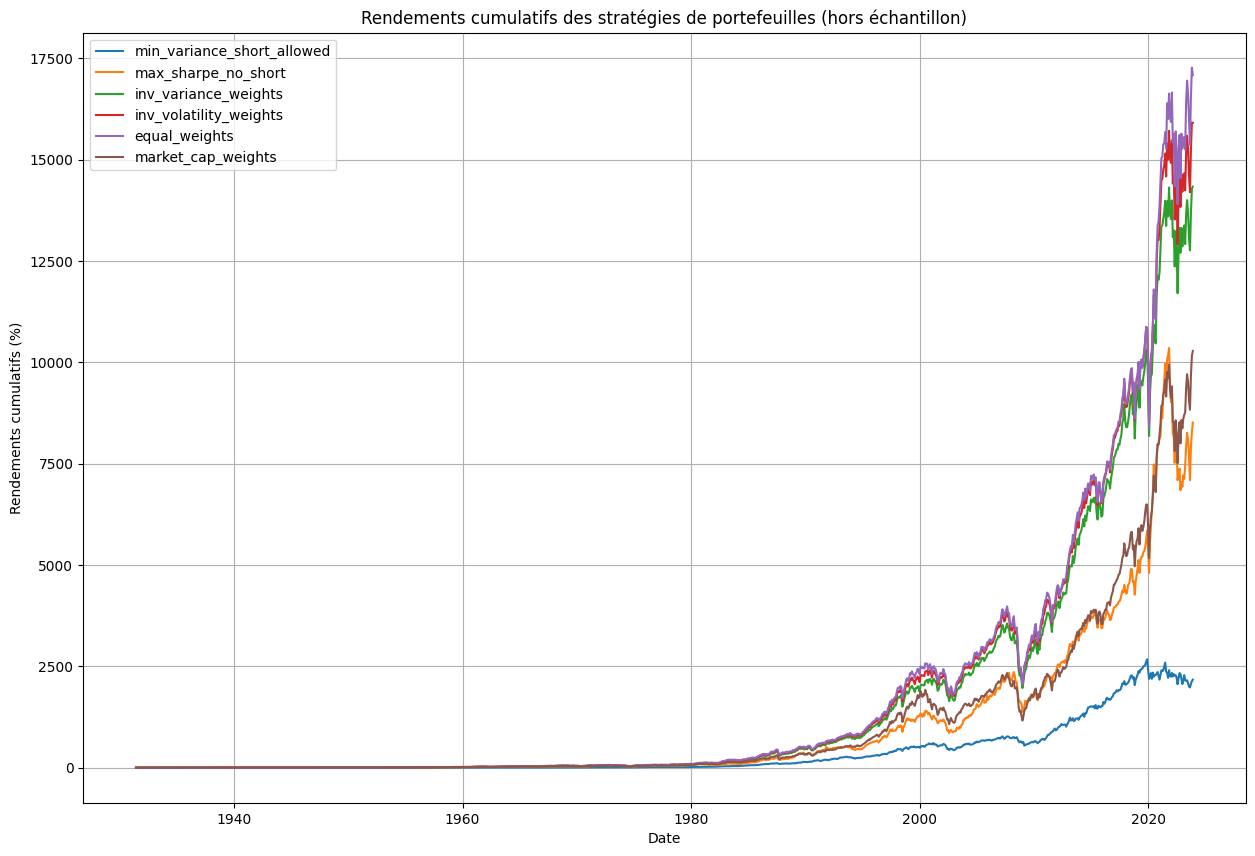

In [226]:
strategies = ['min_variance_short_allowed', 'max_sharpe_no_short', 'inv_variance_weights', 'inv_volatility_weights', 'equal_weights', 'market_cap_weights']
plot_cumulative_returns(df_10Ind, strategies)

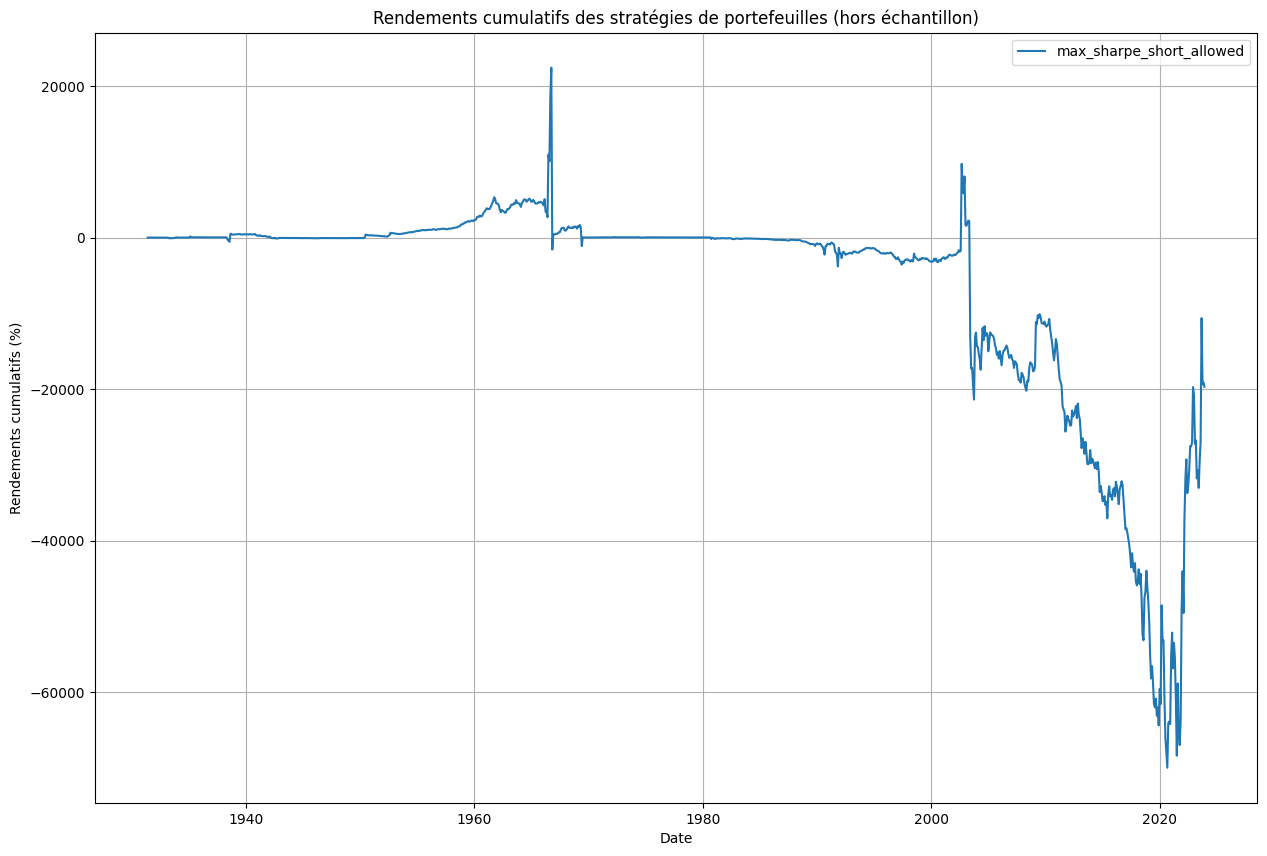

In [227]:
strategies = ['max_sharpe_short_allowed']
plot_cumulative_returns(df_10Ind, strategies)